In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.colors as mcolors
import cmcrameri.cm as cmc
from tqdm import tqdm

# --- Parameters ---
num_fils = 309
num_segs = 20
num_steps_per_file = 500  # Renamed to avoid conflict in loop
sphere_radius = 197.6  # Correct radius for the sphere

# --- File Path Templates ---
date = '20250717'
base_path_template = f'../data/{{sim_name}}/{date}/ciliate_309fil_18000blob_8.00R_0.1500torsion_0.2182tilt_0.3000f_eff_1.4960theta0_0.0000freqshift'
# sim_names = ['emergent_random_1', 'emergent_random_2', 'emergent_random_3']
sim_names = ['yes_tilt_1']

Loading data for yes_tilt_1...
Data loaded.


Generating Animation for yes_tilt_1:  15%|█▍        | 534/3626 [03:09<18:20,  2.81it/s]


CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '1200x1200', '-pix_fmt', 'rgba', '-r', '20', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', 'yes_tilt_1.mp4']' returned non-zero exit status 255.

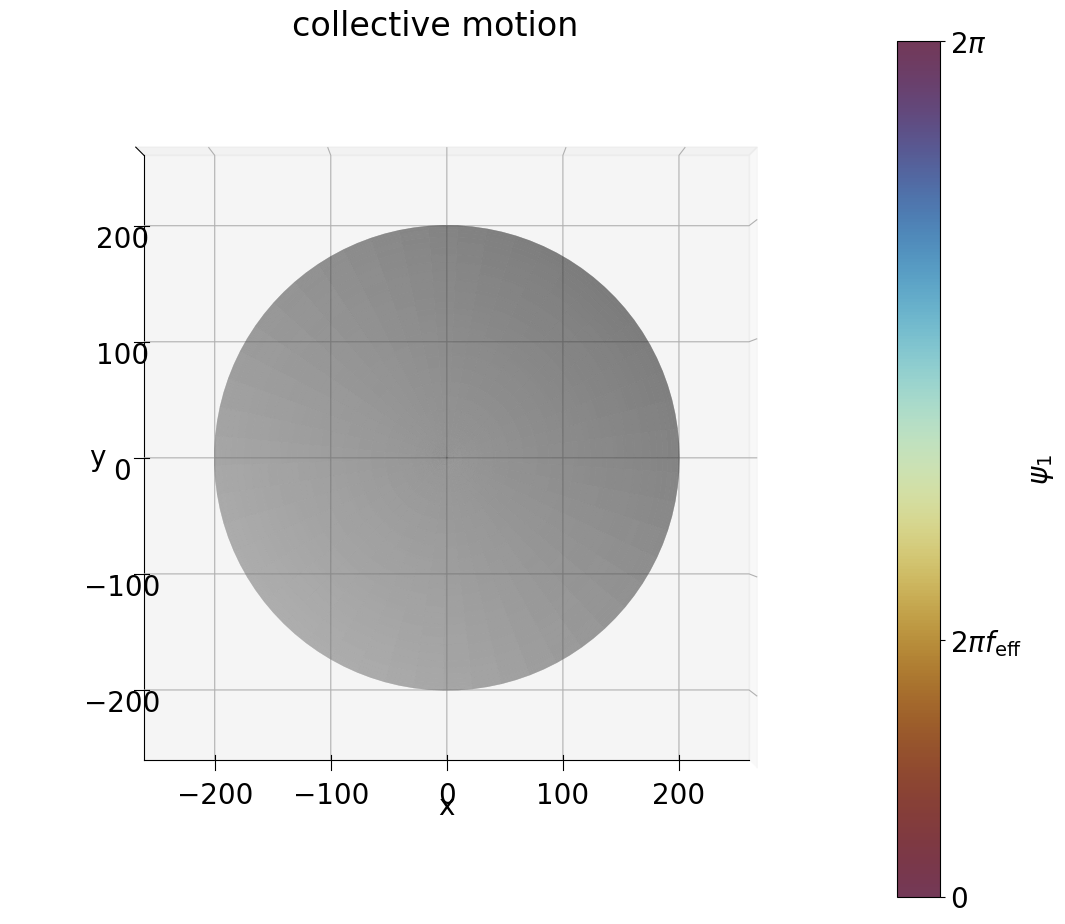

In [6]:
plt.rcParams.update({
    # "text.usetex": True,
    # "font.family": "serif",
    "font.size": 20  # Set the font size here
})

for sim in sim_names:
    # --- Construct file paths ---
    base_path = base_path_template.format(sim_name=sim)
    seg_file_path = f'{base_path}_seg_states.dat'
    phase_file_path = f'{base_path}_true_states.dat'

    # --- Load Data ---
    print(f"Loading data for {sim}...")
    seg_data = np.loadtxt(seg_file_path)
    phase_data = np.loadtxt(phase_file_path)
    print("Data loaded.")

    # --- Process Data ---
    time = seg_data[:, 0] / num_steps_per_file
    num_steps = len(time)

    # Reshape segment data: (time, num_fils, num_segs, 3)
    seg_positions = seg_data[:, 1:].reshape(num_steps, num_fils, num_segs, 3)

    # Extract phases: (time, num_fils)
    phases = np.mod(phase_data[:, 2:num_fils+2], 2*np.pi)

    # --- Animation Setup ---
    fig_anim = plt.figure(figsize=(12, 12))
    ax_anim = fig_anim.add_subplot(111, projection='3d')

    # Create line objects for each cilium
    lines = [ax_anim.plot([], [], [], '-', lw=2)[0] for _ in range(num_fils)]

    # Setup colormap
    cmap = cmc.romaO
    norm = mcolors.Normalize(vmin=0, vmax=2*np.pi)

    def init_anim():
        """Initialize the plot for animation."""
        x_coords = seg_positions[:, :, :, 0]
        y_coords = seg_positions[:, :, :, 1]
        z_coords = seg_positions[:, :, :, 2]
        
        margin = 2.0
        ax_anim.set_xlim(np.min(x_coords) - margin, np.max(x_coords) + margin)
        ax_anim.set_ylim(np.min(y_coords) - margin, np.max(y_coords) + margin)
        ax_anim.set_zlim(np.min(z_coords) - margin, np.max(z_coords) + margin)
        
        ax_anim.set_xlabel('x')
        ax_anim.set_ylabel('y')
        ax_anim.set_title('collective motion')
        ax_anim.set_aspect('equal')
        ax_anim.grid(True, alpha=0.3)

        # Hide z-ticks and z-label
        ax_anim.set_zticks([])
        ax_anim.zaxis.label.set_visible(False)

        # Set view angle for top-down view (x-horizontal, y-vertical)
        ax_anim.view_init(elev=90, azim=-90)
        
        # Plot the sphere
        u = np.linspace(0, 2 * np.pi, 100)
        v = np.linspace(0, np.pi, 100)
        x_sphere = sphere_radius * np.outer(np.cos(u), np.sin(v))
        y_sphere = sphere_radius * np.outer(np.sin(u), np.sin(v))
        z_sphere = sphere_radius * np.outer(np.ones(np.size(u)), np.cos(v))
        ax_anim.plot_surface(x_sphere, y_sphere, z_sphere, color='grey', alpha=0.2)
        
        for line in lines:
            line.set_data([], [])
            line.set_3d_properties([])
        return lines

    def update_anim(frame):
        """Update the plot for each frame."""
        for i, line in enumerate(lines):
            cilium_positions = seg_positions[frame, i, :, :]
            x_data = cilium_positions[:, 0]
            y_data = cilium_positions[:, 1]
            z_data = cilium_positions[:, 2]
            
            line.set_data(x_data, y_data)
            line.set_3d_properties(z_data)
            line.set_color(cmap(norm(phases[frame, i])))
            
        return lines

    # --- Create and Save Animation with Progress Bar ---
    stride = 10
    frames = range(0, num_steps, stride)
    num_frames = len(frames)

    ani = FuncAnimation(fig_anim, update_anim, frames=frames, init_func=init_anim, blit=False, interval=50)

    # Add a colorbar
    sm_anim = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm_anim.set_array([])
    cbar_anim = fig_anim.colorbar(sm_anim, ax=ax_anim, orientation='vertical', fraction=0.046, pad=0.04)
    cbar_anim.set_label(r'$\psi_1$')
    # Set custom ticks for the colorbar
    cbar_anim.set_ticks([0, 0.6*np.pi, 2*np.pi])
    cbar_anim.set_ticklabels([r'$0$', r'$2\pi f_{\mathrm{eff}}$', r'$2\pi$'])

    # Save the animation with a progress bar
    with tqdm(total=num_frames, desc=f"Generating Animation for {sim}") as pbar:
        ani.save(f'{sim}.mp4', writer='ffmpeg', fps=20, progress_callback=lambda i, n: pbar.update(1))

    plt.close(fig_anim)